### Stress Linearization
This example shows how to compute linearized stresses using the library

In [23]:
import numpy as np
from pathlib import WindowsPath
from lib.linearization import APDLIntegrate

def von_mises_from_full(stress: np.ndarray):
    """
    compute von-mises stress intensity from the full (symmetric) stress criterion
    """
    return  np.sqrt(0.5*(np.power(stress[:,0,...] - stress[:,1,...],2.0) + \
                                np.power(stress[:,1,...] - stress[:,2,...],2.0) + \
                                np.power(stress[:,2,...] - stress[:,0,...],2.0) + \
                                6*(np.power(stress[:,3,...],2.0) + np.power(stress[:,4,...],2.0) +\
                                np.power(stress[:,5,...],2.0))))

DPATH = WindowsPath('data')
N_INTEGRATION_POINTS = 47

scl_points = np.load(DPATH.joinpath('pb.interp.loc.npy'))
scl_solution = np.load(DPATH.joinpath('pb.interp.sol.npy'))

apdl_int = APDLIntegrate(scl_solution,scl_points,N_INTEGRATION_POINTS)

membrane = apdl_int.membrane_tensor(averaged = False)                       #computes membrane stress
membrane_vm = apdl_int.membrane_vm(averaged = True)                         #computes membrane vm stress
bending = apdl_int.bending_tensor(averaged = False)                         #computes bending stress
bending_vm = apdl_int.bending_vm(averaged = True)                           #computes bending vm stress
peak = apdl_int.peak_vm(averaged = False)                                   #computes peak stresses
principal = apdl_int.linearized_principal_stress(averaged = False)          #computes linearized principal stresses
triaxility_factor = apdl_int.triaxiality_factor(averaged = False)           #computes the "Triaxility Factor" 

scl_solution = scl_solution.reshape([-1,47,scl_solution.shape[1]]).swapaxes(-1,-2)
scl_points = scl_points.reshape([-1,47,scl_points.shape[1]]).swapaxes(-1,-2)

### Visulization

We'll plot the computed membrane and bending stresses for each of the stress tensor components

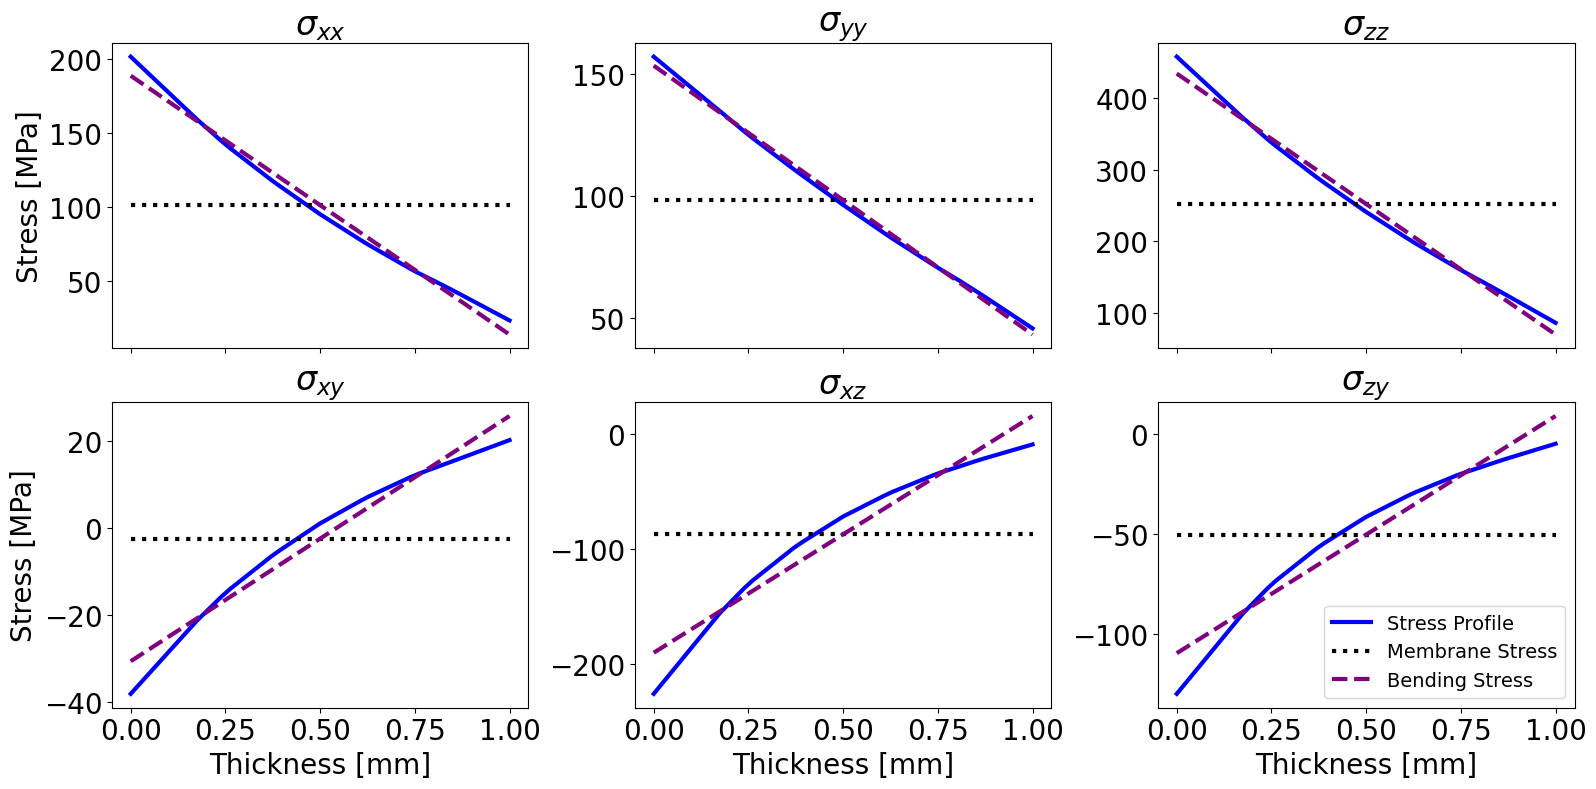

In [19]:
from matplotlib import pyplot as plt

plane_index = 320

fig,axes = plt.subplots(ncols = 3,nrows = 2,figsize = (16,8))
labels = [r'$\sigma_{xx}$',r'$\sigma_{yy}$',r'$\sigma_{zz}$',r'$\sigma_{xy}$',r'$\sigma_{xz}$',r'$\sigma_{zy}$']

xplot = np.linspace(0,1,47)
for i,ax in enumerate(np.ravel(axes)):
    ax.tick_params('both',labelsize = 20)
    ax.set_title(labels[i],fontsize = 24)
    
    _pstress = scl_solution[plane_index,i,::-1]
    ax.plot(xplot,_pstress*1e-6,color = 'blue',linewidth = 3,
         label = 'Stress Profile')
    ax.plot(xplot,membrane[plane_index,i,::-1]*1e-6,color = 'k',linewidth = 3,linestyle = ':',
         label = 'Membrane Stress')
    ax.plot(xplot,membrane[plane_index,i,::-1]*1e-6 + bending[plane_index,i,::-1]*1e-6,
            color = 'purple',linewidth = 3,linestyle = '--',
            label = 'Bending Stress')
    
for i in range(3):
    axes[0,i].set_xticklabels([])
    axes[1,i].set_xlabel('Thickness [mm]',fontsize = 20)

for j in range(2):
    axes[j,0].set_ylabel('Stress [MPa]',fontsize = 20)

np.ravel(axes)[-1].legend(fontsize = 14)
fig.tight_layout()

Do the same for von-mises stress as well

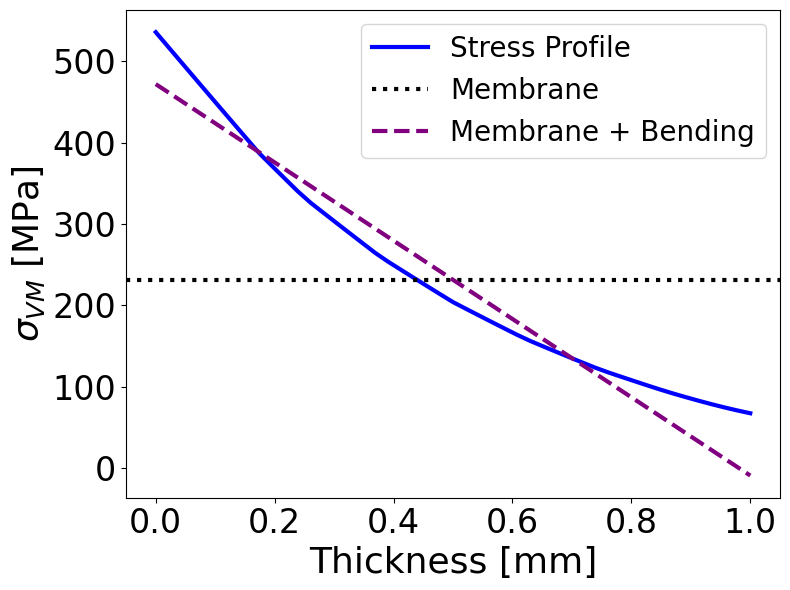

In [25]:
fig,ax = plt.subplots(figsize = (8,6))

vm_stress = von_mises_from_full(scl_solution)

ax.set_xlabel('Thickness [mm]',fontsize= 26)
ax.set_ylabel('$\sigma_{VM}$ [MPa]',fontsize = 26)
ax.tick_params('both',labelsize = 24)
xplot = np.linspace(0,1,47)

ax.plot(xplot,vm_stress[plane_index,::-1]*1e-6,color = 'blue',linewidth = 3,
         label = 'Stress Profile')

yb = np.linspace(bending_vm[plane_index],-bending_vm[plane_index],N_INTEGRATION_POINTS) + membrane_vm[plane_index]
ax.axhline(membrane_vm[plane_index]*1e-6,linewidth = 3,color = 'k',linestyle  =':',label = 'Membrane')
ax.plot(xplot,yb*1e-6,linewidth = 3,color ='purple',linestyle = '--', label = 'Membrane + Bending')
ax.legend(fontsize = 20)
fig.tight_layout()